In [1]:
!pip install pandas
!pip install numpy
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install umap-learn
!pip install openslide-python
!pip install lifelines
!pip install gcsfs
!pip install openslide-python
!pip install torchvision
!pip install openslide-bin

Reading data from GCS bucket: gs://nguyend9_final_project/
Using device: cuda
Found existing processed clinical files. Loading...
Total patients in cohort: 585
Found existing processed omics files. Skipping omics preprocessing.
Found existing imaging file. Checking for completeness...
Imaging file is complete. Skipping imaging pipeline.
Preprocessing Complete
All processed files saved to: gs://nguyend9_final_project/
Loading processed data from GCS for model training...
Loaded and aligned 585 patients for training.
Generating UMAP of raw imaging features
Running UMAP on 585 imaging feature vectors...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved UMAP of raw imaging features to 'raw_imaging_features_umap.png'
Data split into: 409 train, 59 validation, 117 test.
Input dimensions: {'genomics': 100, 'transcriptomics': 100, 'imaging': 2048, 'clinical': 70}
Training SimpleFusion (Baseline) Model
Handling imbalance: Negative=412, Positive=173, Weight=2.38
Starting Model Training with Early Stopping
Epoch 01/100, Loss: 1.0431, Validation Accuracy: 0.7119, Validation F1: 0.0000, Validation AUROC: 0.7311  ** (New Best Model!) **
Epoch 02/100, Loss: 0.9999, Validation Accuracy: 0.7288, Validation F1: 0.1111, Validation AUROC: 0.7339  ** (New Best Model!) **
Epoch 03/100, Loss: 0.9754, Validation Accuracy: 0.7627, Validation F1: 0.3000, Validation AUROC: 0.7059  (No improvement for 1 epochs)
Epoch 04/100, Loss: 0.9084, Validation Accuracy: 0.6780, Validation F1: 0.4571, Validation AUROC: 0.7059  (No improvement for 2 epochs)
Epoch 05/100, Loss: 0.9345, Validation Accuracy: 0.6610, Validation F1: 0.4118, Validation AUROC: 0.7073  (No

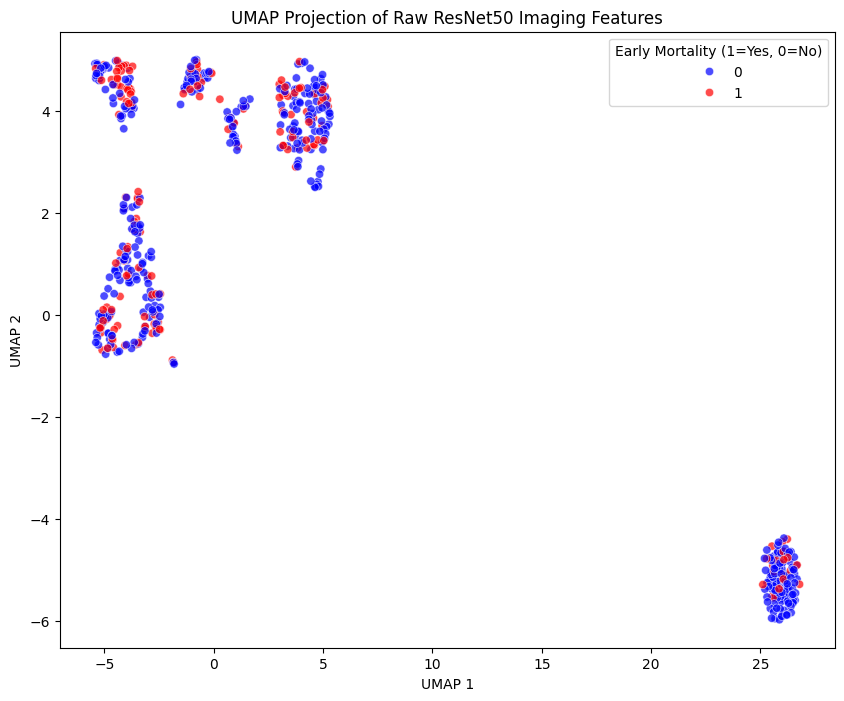

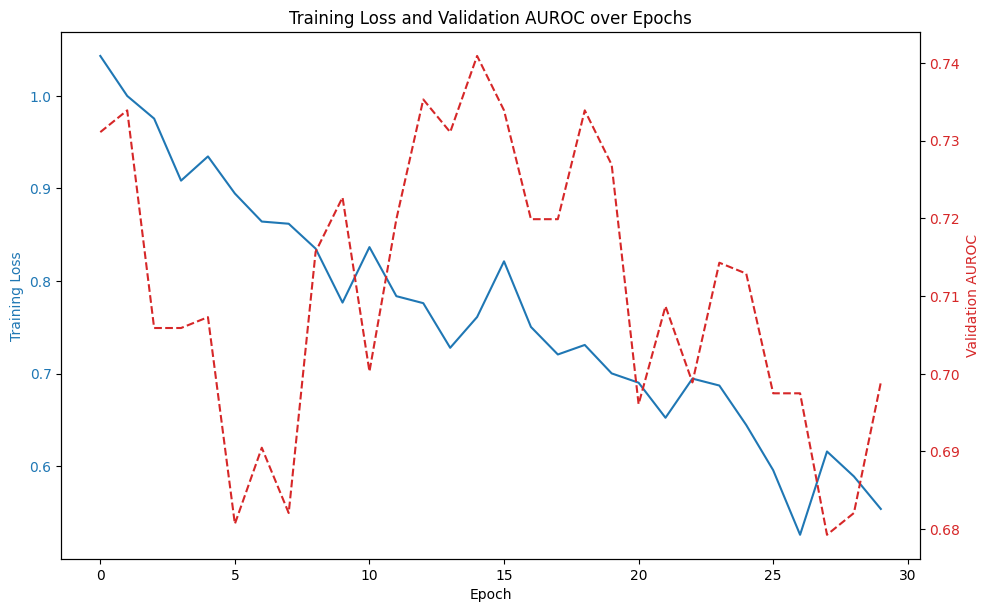

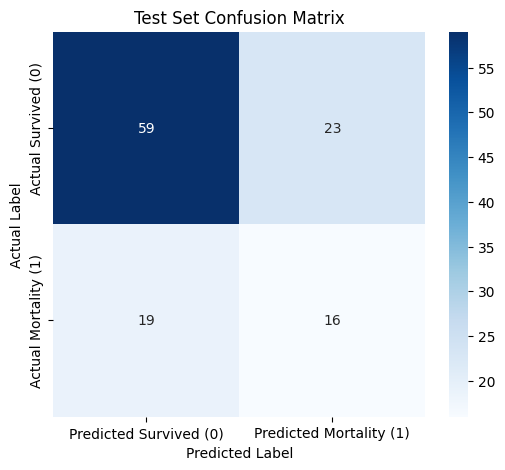

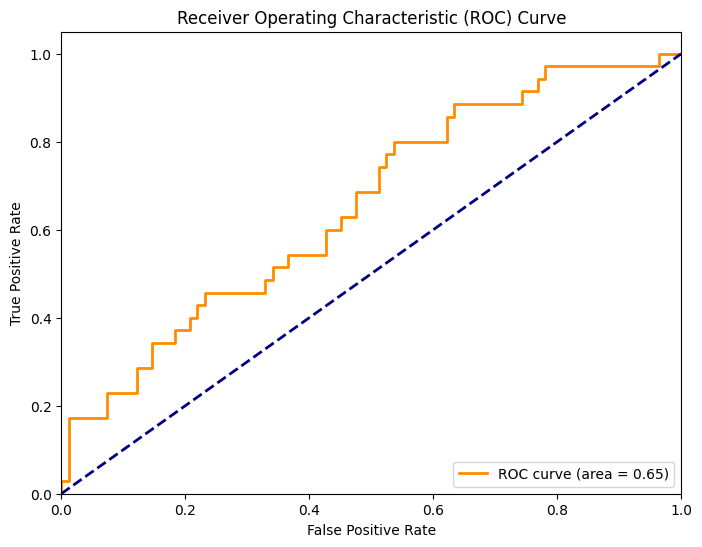

In [3]:
# Importing necessary libraries for data manipulation, deep learning, and analysis.
import os # Importing os for interacting with the operating system (e.g., file paths).
import pandas as pd # Importing pandas for data manipulation and analysis.
import numpy as np # Importing numpy for numerical operations.
import json # Importing json for reading the metadata file.
import warnings # Importing warnings to suppress known DtypeWarnings from pandas.
import torch # Importing torch for building and training neural networks.
import torch.nn as nn # Importing torch.nn for neural network modules.
import torch.optim as optim # Importing torch.optim for optimization algorithms.
from torch.utils.data import Dataset, DataLoader # Importing Dataset and DataLoader for handling data in PyTorch.
from sklearn.model_selection import train_test_split # Importing train_test_split for splitting data into training and testing sets.

# Adding confusion_matrix and roc_curve
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, roc_curve # Importing metrics for model evaluation.

from sklearn.preprocessing import StandardScaler, OneHotEncoder # Importing tools for feature scaling and encoding.
from sklearn.impute import SimpleImputer # Importing SimpleImputer for handling missing data.
from sklearn.cluster import KMeans # Importing KMeans for clustering data.
import matplotlib.pyplot as plt # Importing matplotlib for plotting.
import seaborn as sns # Importing seaborn for enhanced visualizations.
from umap import UMAP # Importing UMAP for dimensionality reduction and visualization.
import copy # Copying objects for model weights.

# GCP IMPORT
import gcsfs # Allowing pandas and other libraries to read from 'gs://' paths.
import gzip # Reading .gz files from GCS.

# Importing for real imaging
import openslide # Opening whole slide images.
import torchvision.models as models # Loading pre-trained models.
import torchvision.transforms as transforms # Transforming images for models.
from PIL import Image # Handling image data.
# Edit: Won't need to authenticate anymore as I made my bucket public access
"""# Colab and GCS Authentication
from google.colab import auth # Importing authentication utility.
auth.authenticate_user() # Authenticating the user for GCS access.
"""
# Configuration

# Setting the GCS bucket name.
GCS_BUCKET = "nguyend9_final_project" # Defining the GCS bucket name.
# Correcting sub-folder name.
ROOT_FOLDER_NAME = "final_project" # Defining the root folder name.

# Building all paths from the correct base.
BASE_PATH = f"gs://{GCS_BUCKET}/" # Defining the base path for GCS.
# Specifying path for fs.find().
MODALITIES_PATH_FIND = f"{GCS_BUCKET}/{ROOT_FOLDER_NAME}/modalities/" # Defining the path for finding modalities.

# Initializing the GCS File System object.
#fs = gcsfs.GCSFileSystem() # Initializing the GCS file system. Edited bc my bucket is public
fs = gcsfs.GCSFileSystem(token='anon')

### DEBUGGING
# Set to True for testing on a small subset of patients.
DEBUGGING_MODE = False # Setting debugging mode status.
DEBUGGING_PATIENT_LIMIT = 20 # Limiting patients for debugging.

# Defining all file paths using the GCS base path
# Updating to the correct, complete metadata file.
METADATA_FILE = os.path.join(BASE_PATH, "metadata.repository.2025-11-14.json") # Defining path to metadata JSON.

HTTP_BASE = "https://storage.googleapis.com/nguyend9_final_project/"

"""# All clinical-related TSV files
CLINICAL_FILE = os.path.join(BASE_PATH, "clinical.tsv") # Defining path to main clinical file.
FOLLOW_UP_FILE = os.path.join(BASE_PATH, "follow_up.tsv") # Defining path to follow-up file.
EXPOSURE_FILE = os.path.join(BASE_PATH, "exposure.tsv") # Defining path to exposure file.
PATHOLOGY_FILE = os.path.join(BASE_PATH, "pathology_detail.tsv") # Defining path to pathology file.
FAMILY_FILE = os.path.join(BASE_PATH, "family_history.tsv") # Defining path to family history file."""

#Using new path because my bucket is public
# All clinical-related TSV files (Using HTTP links)
CLINICAL_FILE = HTTP_BASE + "clinical.tsv"
FOLLOW_UP_FILE = HTTP_BASE + "follow_up.tsv"
EXPOSURE_FILE = HTTP_BASE + "exposure.tsv"
PATHOLOGY_FILE = HTTP_BASE + "pathology_detail.tsv"
FAMILY_FILE = HTTP_BASE + "family_history.tsv"

# Output files will also be saved to your bucket
OUTPUT_PATH = BASE_PATH # Defining the output folder path.
PROCESSED_CLINICAL_FILE = os.path.join(OUTPUT_PATH, "processed_clinical.csv") # Defining filename for clinical features.
PROCESSED_LABELS_FILE = os.path.join(OUTPUT_PATH, "processed_labels.csv") # Defining filename for target labels.
PROCESSED_GENOMICS_FILE = os.path.join(OUTPUT_PATH, "processed_genomics.csv") # Defining filename for genomics matrix.
PROCESSED_TRANSCRIPTOMICS_FILE = os.path.join(OUTPUT_PATH, "processed_transcriptomics.csv") # Defining filename for transcriptomics matrix.
PROCESSED_IMAGING_FILE = os.path.join(OUTPUT_PATH, "processed_imaging_features.csv") # Defining filename for imaging features.

print(f"Reading data from GCS bucket: {BASE_PATH}") # Printing current GCS bucket path.

# New imaging feature extraction
# These functions replace the mock imaging data pipeline.
# They are placed here so they can be called by process_imaging_data.

def load_feature_extractor(device): # Defining function to load feature extractor.
    """
    Loads the pre-trained ResNet50 model and prepares it for feature extraction.
    """
    # Loading a pre-trained ResNet50.
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2) # Initializing ResNet50 with pre-trained weights.

    # "Chopping off" the final classification layer.
    # Using the output of the layer *before* it, a 2048-dim vector.
    model.fc = nn.Identity() # Replacing final layer with identity for feature extraction.

    model = model.to(device) # Moving model to the specified device (CPU/GPU).
    model.eval() # Setting model to evaluation mode.

    # Defining the image transforms (matching ImageNet).
    transform = transforms.Compose([ # Composing image transformations.
        transforms.Resize(256), # Resizing image to 256.
        transforms.CenterCrop(224), # Cropping image to 224 from center.
        transforms.ToTensor(), # Converting image to PyTorch tensor.
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing image pixel values.
    ])

    return model, transform # Returning the model and transform.

def extract_features_for_svs(svs_path, model, transform, device, patch_size=256, level=0, batch_size=64): # Defining function to extract features from SVS.
    """
    Batched inference: Opens a single .svs file, tiles it, and returns an aggregated feature vector.
    """

    local_temp_path = "temp_slide.svs" # Defining temporary path for slide.

    try: # Trying to download and open slide.
        print(f"  > Downloading slide: {svs_path}...") # Printing download message.
        fs.get(svs_path, local_temp_path) # Downloading slide from GCS.
        slide = openslide.OpenSlide(local_temp_path) # Opening the SVS slide.
        print(f"  > Slide open. Tiling and extracting patches...") # Printing status.
    except Exception as e: # Handling exceptions during slide processing.
        print(f"  > Warning: Could not open/download slide {svs_path}. Error: {e}") # Printing warning message.
        if os.path.exists(local_temp_path): # Checking if temporary file exists.
            os.remove(local_temp_path) # Removing temporary file.
        return None # Returning None if error occurs.

    allPatchFeatures = [] # Initializing list for all patch features.
    patchBatch = [] # Initializing batch list.
    width, height = slide.level_dimensions[level] # Getting slide dimensions at specified level.

    for y in range(0, height, patch_size): # Iterating over y-coordinates for tiling.
        for x in range(0, width, patch_size): # Iterating over x-coordinates for tiling.
            try: # Trying to read patch.
                patch = slide.read_region((x, y), level, (patch_size, patch_size)) # Reading a region (patch) from the slide.
                patchPil = patch.convert('RGB') # Converting patch to PIL RGB format.
            except Exception: # Handling exceptions during patch reading.
                continue # Continuing to the next patch.

            grayPatch = patchPil.convert('L') # Converting patch to grayscale.
            if np.mean(grayPatch) > 220: # Checking for mostly white (background) patches.
                continue # Skipping background patches.

            # Batching Logic
            # Transforming patch and adding to the batch.
            transformedPatch = transform(patchPil) # Applying transformations to the patch.
            patchBatch.append(transformedPatch) # Adding transformed patch to batch.

            # When batch is full, sending it to the GPU.
            if len(patchBatch) == batch_size: # Checking if batch is full.
                with torch.no_grad(): # Disabling gradient calculations.
                    # Stacking all patches into a single tensor: [64, 3, 224, 224].
                    batchTensor = torch.stack(patchBatch).to(device) # Stacking and moving batch to device.
                    # Running the model ONCE on the entire batch.
                    features = model(batchTensor) # Extracting features using the model.
                    # Appending all 64 feature vectors to our main list.
                    allPatchFeatures.append(features.cpu().numpy()) # Appending features to list.
                patchBatch = [] # Clearing the batch.

    # Processing any remaining patches
    if len(patchBatch) > 0: # Checking for remaining patches in batch.
        with torch.no_grad(): # Disabling gradient calculations.
            batchTensor = torch.stack(patchBatch).to(device) # Stacking and moving batch to device.
            features = model(batchTensor) # Extracting features.
            allPatchFeatures.append(features.cpu().numpy()) # Appending features to list.

    slide.close() # Closing the openslide object.

    try: # Trying to remove temporary file.
        os.remove(local_temp_path) # Removing local temporary slide file.
    except Exception as e: # Handling exceptions during file removal.
        print(f"  > Warning: Could not delete temp file {local_temp_path}. Error: {e}") # Printing warning message.

    if not allPatchFeatures: # Checking if any features were extracted.
        print(f"  > Warning: No valid tissue patches found in {svs_path}.") # Printing warning.
        return None # Returning None if no valid patches.

    # Aggregation Step (must now vstack all *batches*)
    # Calculating exact patch count.
    totalPatches = sum(batch.shape[0] for batch in allPatchFeatures) # Summing total patches.
    print(f"  > Found {totalPatches} valid tissue patches. Aggregating features...") # Printing patch count.

    allPatchFeatures = np.vstack(allPatchFeatures) # Vertically stacking all patch features.
    aggregatedFeatures = np.mean(allPatchFeatures, axis=0) # Calculating mean of features.

    return aggregatedFeatures # Returning aggregated features.

# Data preprocessing pipeline

def load_and_process_clinical_data(): # Defining function to load and process clinical data.
    """
    Loads and merges all clinical-related TSV files from GCS, creates the target label,
    and saves the processed clinical features and labels back to GCS.
    """
    print("Processing Clinical Data") # Logging start of clinical data processing.
    warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning) # Suppressing DtypeWarning.

    try: # Trying to load clinical data files.
        # Loading main clinical file.
        clinicalDataFrame = pd.read_csv(CLINICAL_FILE, sep='\t') # Reading main clinical TSV.
        print(f"Loaded clinical.tsv: {clinicalDataFrame.shape}") # Printing shape of clinicalDataFrame.

        # Using follow_up.tsv for survival data.
        followUpDataFrame = pd.read_csv(FOLLOW_UP_FILE, sep='\t') # Reading follow-up TSV.
        print(f"Loaded follow_up.tsv: {followUpDataFrame.shape}") # Printing shape of followUpDataFrame.

        # Using exposure.tsv for smoking history.
        exposureDataFrame = pd.read_csv(EXPOSURE_FILE, sep='\t') # Reading exposure TSV.
        print(f"Loaded exposure.tsv: {exposureDataFrame.shape}") # Printing shape of exposureDataFrame.

        # Using pathology_detail.tsv for tumor grade.
        pathologyDataFrame = pd.read_csv(PATHOLOGY_FILE, sep='\t') # Reading pathology TSV.
        print(f"Loaded pathology_detail.tsv: {pathologyDataFrame.shape}") # Printing shape of pathologyDataFrame.

        # Using family_history.tsv for family history.
        familyDataFrame = pd.read_csv(FAMILY_FILE, sep='\t') # Reading family history TSV.
        print(f"Loaded family_history.tsv: {familyDataFrame.shape}") # Printing shape of familyDataFrame.

    except FileNotFoundError as e: # Handling file not found error.
        print(f"Error: {e}. Make sure all .tsv files are in your GCS bucket.") # Printing error message.
        return None, None # Returning None for dataframes.
    except Exception as e: # Handling general exceptions.
        print(f"An unexpected error occurred loading clinical data: {e}") # Printing error message.
        return None, None # Returning None for dataframes.

    # Merging Clinical Data
    clinicalDataFrame = clinicalDataFrame.drop_duplicates(subset=['cases.case_id'], keep='first') # Dropping duplicate clinical entries.
    followUpDataFrame = followUpDataFrame.drop_duplicates(subset=['cases.case_id'], keep='first') # Dropping duplicate follow-up entries.
    exposureDataFrame = exposureDataFrame.drop_duplicates(subset=['cases.case_id'], keep='first') # Dropping duplicate exposure entries.
    pathologyDataFrame = pathologyDataFrame.drop_duplicates(subset=['cases.case_id'], keep='first') # Dropping duplicate pathology entries.
    familyDataFrame = familyDataFrame.drop_duplicates(subset=['cases.case_id'], keep='first') # Dropping duplicate family history entries.

    # Merging all dataframes on 'cases.case_id'.
    mergedDataFrame = pd.merge(clinicalDataFrame, followUpDataFrame, on='cases.case_id', how='left', suffixes=('', '_followup')) # Merging clinical and follow-up data.
    mergedDataFrame = pd.merge(mergedDataFrame, exposureDataFrame, on='cases.case_id', how='left', suffixes=('', '_exposure')) # Merging with exposure data.
    mergedDataFrame = pd.merge(mergedDataFrame, pathologyDataFrame, on='cases.case_id', how='left', suffixes=('', '_pathology')) # Merging with pathology data.
    mergedDataFrame = pd.merge(mergedDataFrame, familyDataFrame, on='cases.case_id', how='left', suffixes=('', '_family')) # Merging with family history data.

    mergedDataFrame = mergedDataFrame.set_index('cases.case_id') # Setting 'cases.case_id' as index.
    print(f"Merged all clinical data. Final shape: {mergedDataFrame.shape}") # Printing merged dataframe shape.

    # Creating Target Label (5-Year Mortality)
    mergedDataFrameCopy = mergedDataFrame.copy() # Creating a copy of the merged dataframe.
    mergedDataFrameCopy['days_to_death'] = pd.to_numeric(mergedDataFrameCopy['demographic.days_to_death'], errors='coerce') # Converting 'days_to_death' to numeric.

    FIVE_YEARS_IN_DAYS = 1825 # Defining 5 years in days.

    mergedDataFrameCopy['early_mortality'] = ( # Calculating early mortality.
        (mergedDataFrameCopy['demographic.vital_status'] == 'Dead') & # Checking for vital status 'Dead'.
        (mergedDataFrameCopy['days_to_death'] <= FIVE_YEARS_IN_DAYS) # Checking for death within 5 years.
    ).astype(int) # Converting boolean to integer.

    mergedDataFrame = mergedDataFrameCopy # Updating mergedDataFrame with early mortality column.

    labels = mergedDataFrame[['early_mortality']] # Extracting early_mortality as labels.
    labels.to_csv(PROCESSED_LABELS_FILE) # Saving labels to CSV.
    print(f"Target labels created. {labels['early_mortality'].sum()} positive cases.") # Printing label summary.
    print(f"Saved labels to {PROCESSED_LABELS_FILE}") # Printing save path.

    # Target Label Distribution Plot
    try: # Trying to generate plot.
        plt.figure(figsize=(6, 4)) # Creating a new figure.
        sns.countplot(x='early_mortality', data=labels) # Generating count plot.
        plt.title('Target Label Distribution (0 = Survived 5+ Yrs, 1 = Early Mortality)') # Setting plot title.
        plt.xlabel('Early Mortality') # Setting x-axis label.
        plt.ylabel('Patient Count') # Setting y-axis label.
        plt.savefig("target_label_distribution.png") # Saving the plot.
        print("Saved target label distribution plot to 'target_label_distribution.png'") # Printing save message.
    except Exception as e: # Handling exceptions during plot generation.
        print(f"Warning: Could not generate label distribution plot. Error: {e}") # Printing warning.

    # Feature Engineering & Preprocessing
    featureColumns = [ # Defining list of feature columns.
        'demographic.age_at_index',
        'diagnoses.ajcc_pathologic_stage',
        'exposures.tobacco_smoking_status',
        'pathology_details.tumor_grade',
        'family_histories.relative_with_cancer_history'
    ]

    existingFeatures = [col for col in featureColumns if col in mergedDataFrame.columns] # Filtering for existing features.
    featuresDataFrame = mergedDataFrame[existingFeatures].copy() # Creating a dataframe with existing features.
    print(f"Using features: {existingFeatures}") # Printing used features.

    # Handling Missing Values & Scaling
    numericalFeatures = featuresDataFrame.select_dtypes(include=np.number).columns.tolist() # Identifying numerical features.
    categoricalFeatures = featuresDataFrame.select_dtypes(exclude=np.number).columns.tolist() # Identifying categorical features.

    if numericalFeatures: # Checking for numerical features.
        numericalImputer = SimpleImputer(strategy='mean') # Initializing numerical imputer.
        featuresDataFrame[numericalFeatures] = numericalImputer.fit_transform(featuresDataFrame[numericalFeatures]) # Imputing numerical features.

        scaler = StandardScaler() # Initializing standard scaler.
        featuresDataFrame[numericalFeatures] = scaler.fit_transform(featuresDataFrame[numericalFeatures]) # Scaling numerical features.
        print(f"Imputed and scaled numerical features: {numericalFeatures}") # Printing status.

    if categoricalFeatures: # Checking for categorical features.
        featuresDataFrame[categoricalFeatures] = featuresDataFrame[categoricalFeatures].fillna('Missing') # Filling missing categorical values.
        featuresDataFrame[categoricalFeatures] = featuresDataFrame[categoricalFeatures].replace("'--", "Missing") # Replacing specific string with 'Missing'.
        featuresDataFrame[categoricalFeatures] = featuresDataFrame[categoricalFeatures].replace("Not Reported", "Missing") # Replacing 'Not Reported' with 'Missing'.
        featuresDataFrame[categoricalFeatures] = featuresDataFrame[categoricalFeatures].replace("Unknown", "Missing") # Replacing 'Unknown' with 'Missing'.

        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # Initializing one-hot encoder.
        encodedColumns = encoder.fit_transform(featuresDataFrame[categoricalFeatures]) # Encoding categorical features.
        encodedDataFrame = pd.DataFrame(encodedColumns, index=featuresDataFrame.index, columns=encoder.get_feature_names_out(categoricalFeatures)) # Creating dataframe from encoded columns.

        featuresDataFrame = featuresDataFrame.drop(columns=categoricalFeatures).join(encodedDataFrame) # Joining encoded dataframe.
        print(f"Imputed and one-hot encoded categorical features: {categoricalFeatures}") # Printing status.

    featuresDataFrame.to_csv(PROCESSED_CLINICAL_FILE) # Saving processed clinical features.
    print(f"Processed clinical features saved to {PROCESSED_CLINICAL_FILE}") # Printing save path.

    return featuresDataFrame, labels # Returning processed features and labels.

def build_file_to_case_map(): # Defining function to build file-to-case map.
    """
    Loads the metadata JSON from GCS and creates a dictionary that maps
    file_name to case_id.
    """
    print("Building File-to-Case ID Map") # Logging start of map building.
    try: # Trying to open metadata file.
        with fs.open(METADATA_FILE, 'r') as fileHandle: # Opening metadata file.
            metadata = json.load(fileHandle) # Loading JSON data.
    except FileNotFoundError: # Handling file not found error.
        print(f"CRITICAL ERROR: {METADATA_FILE} not found.") # Printing critical error.
        return None # Returning None.
    except json.JSONDecodeError: # Handling JSON decode error.
        print(f"CRITICAL ERROR: {METADATA_FILE} is not a valid JSON file.") # Printing critical error.
        return None # Returning None.

    fileToCaseMap = {} # Initializing file-to-case map.
    for entry in metadata: # Iterating through metadata entries.
        fileName = entry.get('file_name') # Getting file name.
        if entry.get('associated_entities'): # Checking for associated entities.
            caseId = entry['associated_entities'][0].get('case_id') # Getting case ID.
            if fileName and caseId: # Checking if file name and case ID exist.
                fileToCaseMap[fileName] = caseId # Adding to map.

    print(f"Built map for {len(fileToCaseMap)} files.") # Printing map size.
    return fileToCaseMap # Returning the map.

def process_omics_files(fileToCaseMap, caseIdIndex): # Defining function to process omics files.
    """
    Scans the GCS bucket for omics files, processes them, and saves the results back to GCS.
    """
    print("Processing Genomics & Transcriptomics Files") # Logging start of omics processing.
    if fileToCaseMap is None: # Checking if file-to-case map is missing.
        print("Skipping omics processing: fileToCaseMap is missing.") # Printing skip message.
        return # Exiting function.

    genomicsData = [] # Initializing list for genomics data.
    transcriptomicsData = [] # Initializing list for transcriptomics data.

    print(f"Scanning {MODALITIES_PATH_FIND} for all files... (This may take a moment)") # Printing scan message.
    allFiles = fs.find(MODALITIES_PATH_FIND) # Finding all files in modalities path.
    print(f"Found {len(allFiles)} total files in modalities. Filtering...") # Printing file count.

    rnaFiles = [] # Initializing list for RNA files.
    mafFiles = [] # Initializing list for MAF files.
    for f in allFiles: # Iterating through all found files.
        if f.endswith(".rna_seq.augmented_star_gene_counts.tsv"): # Checking for RNA files.
            rnaFiles.append(f) # Adding to RNA files list.
        elif f.endswith(".maf.gz"): # Checking for MAF files.
            mafFiles.append(f) # Adding to MAF files list.

    # Processing Transcriptomics (Gene Expression)
    print(f"Found {len(rnaFiles)} transcriptomics files. Processing...") # Printing RNA file count.
    for fullPath in rnaFiles: # Iterating through RNA files.
        fileName = os.path.basename(fullPath) # Extracting filename.
        caseId = fileToCaseMap.get(fileName) # Getting case ID from filename.
        if not caseId or caseId not in caseIdIndex: # Checking if case ID is valid and in index.
            continue # Skipping if invalid.

        try: # Trying to process transcriptomics file.
            gcsPath = f"gs://{fullPath}" # Constructing GCS path.
            # Added storage_options={'token': 'anon'} so Pandas knows it's public
            dataFrame = pd.read_csv(gcsPath, sep='\t', header=1, storage_options={'token': 'anon'})
            dataFrame = dataFrame.drop_duplicates(subset=['gene_name'], keep='first').set_index('gene_name')
            tpmSeries = np.log2(dataFrame['tpm_unstranded'] + 1) # Calculating log2(TPM+1).
            transcriptomicsData.append((caseId, tpmSeries)) # Appending to transcriptomics data.
        except Exception as e: # Handling exceptions during processing.
            print(f"Warning: Could not process file {fileName}. Error: {e}") # Printing warning message.

    # Processing Genomics (Somatic Mutations)
    print(f"Found {len(mafFiles)} genomics files. Processing...") # Printing MAF file count.

    for fullPath in mafFiles: # Iterating through MAF files.
        fileName = os.path.basename(fullPath) # Extracting filename.
        caseId = fileToCaseMap.get(fileName) # Getting case ID from filename.

        if not caseId or caseId not in caseIdIndex: # Checking if case ID is valid and in index.
            continue # Skipping if invalid.

        try: # Trying to process genomics file.
            with fs.open(fullPath, 'rb') as fileHandle: # Opening compressed file.
                with gzip.open(fileHandle, 'rt') as gzippedFile: # Decompressing file.
                    dataFrame = pd.read_csv(gzippedFile, sep='\t', comment='#', low_memory=False) # Reading genomics data.

            mutationCounts = dataFrame['Hugo_Symbol'].value_counts() # Counting mutations per gene.
            genomicsData.append((caseId, mutationCounts)) # Appending to genomics data.
        except Exception as e: # Handling exceptions during processing.
            print(f"Warning: Could not process file {fileName}. Error: {e}") # Printing warning message.

    print(f"Finished scanning. Processed {len(transcriptomicsData)} transcriptomics files and {len(genomicsData)} genomics files.") # Printing scan summary.

    # Assembling and Saving Transcriptomics
    if transcriptomicsData: # Checking if transcriptomics data exists.
        tDataFrame = pd.DataFrame.from_dict(dict(transcriptomicsData), orient='index') # Creating dataframe from dict.
        tDataFrame = tDataFrame.reindex(caseIdIndex).fillna(0) # Reindexing and filling NaNs.

        topGenes = tDataFrame.var().sort_values(ascending=False).head(100).index # Selecting top 100 variable genes.
        tDataFrame = tDataFrame[topGenes] # Filtering for top genes.

        print("Applying StandardScaler to transcriptomics data...") # Printing status.
        scaler = StandardScaler() # Initializing scaler.
        tDataFrameScaled = scaler.fit_transform(tDataFrame) # Scaling transcriptomics data.
        tDataFrame = pd.DataFrame(tDataFrameScaled, index=tDataFrame.index, columns=tDataFrame.columns) # Creating dataframe from scaled data.

        tDataFrame.to_csv(PROCESSED_TRANSCRIPTOMICS_FILE) # Saving processed transcriptomics data.
        print(f"Processed transcriptomics data and saved to {PROCESSED_TRANSCRIPTOMICS_FILE} with shape {tDataFrame.shape}") # Printing save details.
    else: # If no transcriptomics data found.
        # Creating mock transcriptomics data if none found.
        print("Warning: No transcriptomics files found. Creating mock transcriptomics data.") # Printing warning.
        numberOfPatients = len(caseIdIndex) # Getting number of patients.
        numberOfFeatures = 100 # Defining number of mock features.
        mockFeatures = np.random.randn(numberOfPatients, numberOfFeatures) # Generating random mock features.
        featureNames = [f"MOCK_TRN_GENE_{i}" for i in range(numberOfFeatures)] # Creating mock feature names.
        tDataFrame = pd.DataFrame(mockFeatures, index=caseIdIndex, columns=featureNames) # Creating mock dataframe.
        tDataFrame.to_csv(PROCESSED_TRANSCRIPTOMICS_FILE) # Saving mock data.
        print(f"Mock transcriptomics data saved to {PROCESSED_TRANSCRIPTOMICS_FILE} with shape {tDataFrame.shape}") # Printing save details.


    # Assembling and Saving Genomics
    if genomicsData: # Checking if genomics data exists.
        gDataFrame = pd.DataFrame.from_dict(dict(genomicsData), orient='index') # Creating dataframe from dict.
        gDataFrame = gDataFrame.reindex(caseIdIndex).fillna(0) # Reindexing and filling NaNs.
        gDataFrame = (gDataFrame > 0).astype(int) # Converting to binary (presence/absence).

        topGenes = gDataFrame.sum().sort_values(ascending=False).head(100).index # Selecting top 100 frequently mutated genes.
        gDataFrame = gDataFrame[topGenes] # Filtering for top genes.

        print("Genomics data is binary, no scaling needed.") # Printing status.

        gDataFrame.to_csv(PROCESSED_GENOMICS_FILE) # Saving processed genomics data.
        print(f"Processed genomics data and saved to {PROCESSED_GENOMICS_FILE} with shape {gDataFrame.shape}") # Printing save details.
    else: # If no genomics data found.
        # Creating mock genomics data if none found.
        print("Warning: No genomics files found. Creating mock genomics data.") # Printing warning.
        numberOfPatients = len(caseIdIndex) # Getting number of patients.
        numberOfFeatures = 100 # Defining number of mock features.
        mockFeatures = (np.random.rand(numberOfPatients, numberOfFeatures) > 0.95).astype(int) # Generating random binary mock features.
        featureNames = [f"MOCK_GEN_GENE_{i}" for i in range(numberOfFeatures)] # Creating mock feature names.
        gDataFrame = pd.DataFrame(mockFeatures, index=caseIdIndex, columns=featureNames) # Creating mock dataframe.
        gDataFrame.to_csv(PROCESSED_GENOMICS_FILE) # Saving mock data.
        print(f"Mock genomics data saved to {PROCESSED_GENOMICS_FILE} with shape {gDataFrame.shape}") # Printing save details.


def process_imaging_data(caseIdIndex, fileToCaseMap, device): # Defining function to process imaging data.
    """
    Batched inference: Finds .svs files, extracts features, and saves progress incrementally.
    """
    print("Processing Imaging Data (REAL)") # Logging start of imaging processing.

    print("Loading pre-trained ResNet50 feature extractor...") # Printing loading message.
    featureExtractor, transform = load_feature_extractor(device) # Loading feature extractor and transform.
    print("Feature extractor loaded.") # Printing status.

    # Finding all available .svs files in the bucket
    print("Finding all .svs files in bucket...") # Printing search message.
    allFiles = fs.find(MODALITIES_PATH_FIND) # Finding all files in modalities path.
    filenameToFullPath = {os.path.basename(f): f"gs://{f}" for f in allFiles if f.endswith('.svs')} # Mapping filenames to full GCS paths.
    print(f"Found {len(filenameToFullPath)} .svs files.") # Printing count of SVS files.

    # Mapping case IDs to their specific .svs file
    caseToSvsFileMap = {} # Initializing map from case ID to SVS filename.
    for fileName, caseId in fileToCaseMap.items(): # Iterating through file-to-case map.
        if fileName.endswith('.svs'): # Checking for SVS files.
            caseToSvsFileMap[caseId] = fileName # Mapping case ID to SVS file.
    print(f"Mapped {len(caseToSvsFileMap)} case IDs to .svs files from metadata.") # Printing mapped count.

    # Atomic checkpointing logic
    allImagingFeatures = [] # Initializing list for all imaging features.
    patientIdsWithImaging = [] # Initializing list for patient IDs with imaging.
    processedPatients = set() # Initializing set for processed patients.

    # Defining a temp file path for safe saving
    CHECKPOINT_TEMP_FILE = os.path.join(OUTPUT_PATH, "processed_imaging_features_TEMP.csv") # Defining temporary checkpoint file path.

    try: # Trying to load existing processed file.
        # Checking if the *main* file exists and is valid.
        if fs.exists(PROCESSED_IMAGING_FILE): # Checking if processed imaging file exists.
            print(f"Found existing processed file: {PROCESSED_IMAGING_FILE}. Resuming from last checkpoint.") # Printing resume message.
            with fs.open(PROCESSED_IMAGING_FILE, 'r') as fileHandle: # Opening processed imaging file.
                tempDataFrame = pd.read_csv(fileHandle, index_col=0) # Reading CSV into temporary dataframe.

            # Checking for corruption (empty or single-column).
            if tempDataFrame.shape[0] > 0 and tempDataFrame.shape[1] > 1: # Checking dataframe dimensions.
                processedPatients = set(tempDataFrame.index) # Populating processed patients set.
                patientIdsWithImaging = list(tempDataFrame.index) # Populating patient IDs list.
                allImagingFeatures = tempDataFrame.values.tolist() # Converting features to list.
                print(f"Loaded {len(processedPatients)} already-processed patients.") # Printing loaded patient count.
            else: # If checkpoint file is empty or corrupt.
                print("Warning: Checkpoint file is empty or corrupt. Starting from scratch.") # Printing warning.
        else: # If no processed file found.
            print("No processed file found. Starting from scratch.") # Printing start message.
    except Exception as e: # Handling exceptions during checkpoint loading.
        print(f"Warning: Could not load checkpoint file. It may be corrupt. Error: {e}") # Printing warning.
        print("Starting from scratch.") # Printing restart message.
        allImagingFeatures = [] # Resetting imaging features list.
        patientIdsWithImaging = [] # Resetting patient IDs list.
        processedPatients = set() # Resetting processed patients set.

    print(f"Extracting imaging features for {len(caseIdIndex)} patients... (This will take many hours)") # Printing extraction message.

    patientsProcessedThisRun = 0 # Initializing counter for patients processed in this run.

    for i, caseId in enumerate(caseIdIndex): # Iterating through case IDs.
        print(f"\nProcessing Patient {i+1}/{len(caseIdIndex)} (Case ID: {caseId})") # Printing patient progress.

        if caseId in processedPatients: # Checking if patient already processed.
            print(f"  > Skipping: Case ID {caseId} already processed.") # Printing skip message.
            continue # Skipping to next patient.

        fileName = caseToSvsFileMap.get(caseId) # Getting SVS filename for case ID.
        if not fileName: # Checking if filename exists.
            print(f"  > Skipping: No .svs file found in metadata for this case.") # Printing skip message.
            continue # Skipping to next patient.

        fullSvsPath = filenameToFullPath.get(fileName) # Getting full SVS path.
        if not fullSvsPath: # Checking if full SVS path exists.
            print(f"  > Skipping: File {fileName} in metadata, but not found in GCS bucket scan.") # Printing skip message.
            continue # Skipping to next patient.

        features = extract_features_for_svs(fullSvsPath, featureExtractor, transform, device) # Extracting features from SVS.

        if features is not None: # Checking if features were successfully extracted.
            print(f"  > Successfully extracted features for Case ID: {caseId}") # Printing success message.
            allImagingFeatures.append(features) # Appending extracted features.
            patientIdsWithImaging.append(caseId) # Appending patient ID.
            patientsProcessedThisRun += 1 # Incrementing processed count.

            # Atomic checkpointing save
            # Saving progress every 5 patients (or on the last patient).
            if (patientsProcessedThisRun % 5 == 0) or (i == len(caseIdIndex) - 1): # Checking for checkpoint condition.
                if not allImagingFeatures: continue # Continuing if no imaging features.

                print(f"\nCheckpointing: Saving progress for {len(patientIdsWithImaging)} patients...") # Printing checkpoint message.
                numberOfFeatures = len(allImagingFeatures[0]) # Getting number of features.
                featureNames = [f"IMG_F_{i}" for i in range(numberOfFeatures)] # Creating feature names.

                tempSaveDataFrame = pd.DataFrame(allImagingFeatures, index=patientIdsWithImaging, columns=featureNames) # Creating temporary dataframe.

                # 1. Saving to a _TEMP file.
                tempSaveDataFrame.to_csv(CHECKPOINT_TEMP_FILE) # Saving temporary dataframe to CSV.

                # 2. Renaming (atomic move) the _TEMP file to the REAL file.
                # This is fast and disconnect-proof.
                try: # Trying to rename file.
                    fs.rename(CHECKPOINT_TEMP_FILE, PROCESSED_IMAGING_FILE) # Renaming temporary file to final file.
                    print("Progress saved to GCS.") # Printing save confirmation.
                except Exception as e: # Handling exceptions during rename.
                    print(f"Warning: Failed to rename checkpoint file. Error: {e}") # Printing warning.

        else: # If feature extraction failed.
            print(f"  > Skipped Case ID: {caseId} (Feature extraction failed or no tissue found)") # Printing skip message.

    # Final Processing
    if not allImagingFeatures: # Checking if any imaging features were collected.
        print("CRITICAL: No imaging features were extracted. Check file paths and .svs files.") # Printing critical error.
        numberOfPatients = len(caseIdIndex) # Getting number of patients.
        numberOfFeatures = 2048 # ResNet50 feature dimension.
        mockFeatures = np.random.randn(numberOfPatients, numberOfFeatures) # Generating mock features.
        featureNames = [f"MOCK_IMG_F_{i}" for i in range(numberOfFeatures)] # Creating mock feature names.
        imagingDataFrame = pd.DataFrame(mockFeatures, index=caseIdIndex, columns=featureNames) # Creating mock dataframe.
    else: # If imaging features were collected.
        print(f"\nImaging Summary") # Printing imaging summary header.
        print(f"Successfully extracted features for {len(patientIdsWithImaging)} total patients.") # Printing count of patients with features.
        print("End Summary") # Printing summary footer.

        numberOfFeatures = len(allImagingFeatures[0]) # Getting number of features.
        featureNames = [f"IMG_F_{i}" for i in range(numberOfFeatures)] # Creating feature names.
        imagingDataFrame = pd.DataFrame(allImagingFeatures, index=patientIdsWithImaging, columns=featureNames) # Creating dataframe from features.

        imagingDataFrame = imagingDataFrame.reindex(caseIdIndex).fillna(0) # Reindexing and filling NaNs.

    # Final saving of the *aligned* file.
    imagingDataFrame.to_csv(PROCESSED_IMAGING_FILE) # Saving processed imaging features.
    print(f"REAL imaging features saved to {PROCESSED_IMAGING_FILE} with shape {imagingDataFrame.shape}") # Printing save details.


# PyTorch Dataset and DataLoader

# Defining a custom PyTorch Dataset for multimodal data.
class MultimodalDataset(Dataset): # Defining the MultimodalDataset class.
    """PyTorch dataset for multimodal data."""
    def __init__(self, data, labels): # Defining the constructor for the dataset.
        super().__init__() # Initializing the parent Dataset class.
        self.data = data # Storing the input data dictionary.
        self.labels = labels # Storing the labels Series.
        self.patientIds = list(self.labels.index) # Extracting patient IDs from the labels index.

    def __len__(self): # Defining the method to return the size of the dataset.
        return len(self.patientIds) # Returning the number of patient IDs.

    def __getitem__(self, idx): # Defining the method to get a sample from the dataset by index.
        patientId = self.patientIds[idx] # Getting the patient ID for the given index.
        genomicsData = torch.tensor(self.data['genomics'].loc[patientId].values, dtype=torch.float32) # Converting genomics data to a PyTorch tensor.
        transcriptomicsData = torch.tensor(self.data['transcriptomics'].loc[patientId].values, dtype=torch.float32) # Converting transcriptomics data to a PyTorch tensor.
        imagingData = torch.tensor(self.data['imaging'].loc[patientId].values, dtype=torch.float32) # Converting imaging data to a PyTorch tensor.
        clinicalData = torch.tensor(self.data['clinical'].loc[patientId].values, dtype=torch.float32) # Converting clinical data to a PyTorch tensor.
        label = torch.tensor(self.labels.loc[patientId], dtype=torch.float32) # Converting the label to a PyTorch tensor.

        return { # Returning a dictionary of tensors for a single sample.
            'genomics': genomicsData, # Returning the genomics tensor.
            'transcriptomics': transcriptomicsData, # Returning the transcriptomics tensor.
            'imaging': imagingData, # Returning the imaging tensor.
            'clinical': clinicalData, # Returning the clinical tensor.
            'label': label.unsqueeze(0) # Returning the label tensor, unsqueezed to have a dimension for the batch.
        }


# Model Architectures

# Unimodal Models (Baselines)
class UnimodalMlp(nn.Module): # Defining the UnimodalMlp class.
    """A simple MLP for any single modality."""
    def __init__(self, inputDimension, hiddenDimension=64, outputDimension=1): # Initializing the MLP.
        super().__init__() # Calling parent constructor.
        self.network = nn.Sequential( # Defining the neural network sequence.
            nn.Linear(inputDimension, hiddenDimension), # Adding first linear layer.
            nn.ReLU(), # Adding ReLU activation.
            nn.Dropout(0.5), # Adding dropout layer.
            nn.Linear(hiddenDimension, hiddenDimension // 2), # Adding second linear layer.
            nn.ReLU(), # Adding ReLU activation.
            nn.Dropout(0.5), # Adding dropout layer.
            nn.Linear(hiddenDimension // 2, outputDimension), # Adding final linear layer.
        )

    def forward(self, x): # Defining the forward pass.
        return self.network(x) # Passing input through the network.

# Simple Concatenation Fusion Model (Baseline)
class SimpleFusion(nn.Module): # Defining the SimpleFusion class.
    """Concatenates all modality features and feeds them to an MLP."""
    def __init__(self, inputDimensions, hiddenDimension=128, outputDimension=1): # Initializing the fusion model.
        super().__init__() # Calling parent constructor.
        totalInputDimension = sum(inputDimensions.values()) # Calculating total input dimension.
        self.fusionNetwork = nn.Sequential( # Defining the fusion network sequence.
            nn.Linear(totalInputDimension, hiddenDimension), # Adding first linear layer.
            nn.ReLU(), # Adding ReLU activation.
            nn.BatchNorm1d(hiddenDimension), # Adding batch normalization.
            nn.Dropout(0.5), # Adding dropout layer.
            nn.Linear(hiddenDimension, hiddenDimension // 2), # Adding second linear layer.
            nn.ReLU(), # Adding ReLU activation.
            nn.BatchNorm1d(hiddenDimension // 2), # Adding batch normalization.
            nn.Dropout(0.5), # Adding dropout layer.
            nn.Linear(hiddenDimension // 2, outputDimension), # Adding final linear layer.
        )

    def forward(self, x): # Defining the forward pass.
        # x is a dictionary of tensors.
        concatenated = torch.cat(list(x.values()), dim=1) # Concatenating all modality features.
        return self.fusionNetwork(concatenated) # Passing concatenated features through the network.


# Heterogeneity-Aware Fusion Model (Proposed)
class ModalityEncoder(nn.Module): # Defining the ModalityEncoder class.
    """A dedicated encoder for each modality."""
    def __init__(self, inputDimension, outputDimension=64): # Initializing the encoder.
        super().__init__() # Calling parent constructor.
        self.encoder = nn.Sequential( # Defining the encoder network.
            nn.Linear(inputDimension, outputDimension), # Adding linear layer.
            nn.ReLU(), # Adding ReLU activation.
            nn.Dropout(0.3) # Adding dropout layer.
        )

    def forward(self, x): # Defining the forward pass.
        return self.encoder(x) # Passing input through the encoder.

class CrossModalAttention(nn.Module): # Defining the CrossModalAttention class.
    """Transformer-based cross-modal attention mechanism."""
    def __init__(self, embeddingDimension=64, numberHeads=4): # Initializing attention mechanism.
        super().__init__() # Calling parent constructor.
        self.attention = nn.MultiheadAttention(embeddingDimension, numberHeads, batch_first=True) # Creating multi-head attention module.

    def forward(self, query, key, value): # Defining the forward pass.
        attentionOutput, _ = self.attention(query, key, value) # Computing attention output.
        return attentionOutput # Returning attention output.

class ProposedFusionModel(nn.Module): # Defining the ProposedFusionModel class.
    """The proposed heterogeneity-aware fusion model."""
    def __init__(self, inputDimensions, embeddingDimension=64, numberHeads=4, hiddenDimension=128, outputDimension=1): # Initializing the fusion model.
        super().__init__() # Calling parent constructor.
        # Modality-Specific Encoders
        self.genomicsEncoder = ModalityEncoder(inputDimensions['genomics'], embeddingDimension) # Creating genomics encoder.
        self.transcriptomicsEncoder = ModalityEncoder(inputDimensions['transcriptomics'], embeddingDimension) # Creating transcriptomics encoder.
        self.imagingEncoder = ModalityEncoder(inputDimensions['imaging'], embeddingDimension) # Creating imaging encoder.
        self.clinicalEncoder = ModalityEncoder(inputDimensions['clinical'], embeddingDimension) # Creating clinical encoder.

        # Cross-Modal Attention
        self.attention = CrossModalAttention(embeddingDimension, numberHeads) # Creating cross-modal attention module.

        # Classifier for Fused Representation
        self.classifier = nn.Sequential( # Defining the classifier network.
            nn.Linear(embeddingDimension * 4, hiddenDimension), # Adding first linear layer.
            nn.ReLU(), # Adding ReLU activation.
            nn.Dropout(0.5), # Adding dropout layer.
            nn.Linear(hiddenDimension, outputDimension), # Adding final linear layer.
        )

    def forward(self, x): # Defining the forward pass.
        # x is a dictionary of tensors.
        genomicsEmbedding = self.genomicsEncoder(x['genomics']) # Encoding genomics data.
        transcriptomicsEmbedding = self.transcriptomicsEncoder(x['transcriptomics']) # Encoding transcriptomics data.
        imagingEmbedding = self.imagingEncoder(x['imaging']) # Encoding imaging data.
        clinicalEmbedding = self.clinicalEncoder(x['clinical']) # Encoding clinical data.

        stackedEmbeddings = torch.stack([genomicsEmbedding, transcriptomicsEmbedding, imagingEmbedding, clinicalEmbedding], dim=1) # Stacking embeddings for attention.
        attentionOutput = self.attention(stackedEmbeddings, stackedEmbeddings, stackedEmbeddings) # Computing attention output.
        fusedRepresentation = attentionOutput.reshape(attentionOutput.size(0), -1) # Reshaping attention output for classifier.

        prediction = self.classifier(fusedRepresentation) # Making prediction using classifier.
        return prediction, fusedRepresentation # Returning prediction and fused representation.


# Training and evaluation
def train_model(model, dataLoader, criterion, optimizer, device): # Defining function for model training.
    """Training loop for one epoch."""
    model.train() # Setting model to training mode.
    runningLoss = 0.0 # Initializing running loss.
    for batch in dataLoader: # Iterating through data batches.
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'} # Moving inputs to device.
        labels = batch['label'].to(device) # Moving labels to device.

        optimizer.zero_grad() # Zeroing optimizer gradients.

        # Cleaning up logic
        if isinstance(model, ProposedFusionModel): # Checking model type.
            outputs, _ = model(inputs) # Getting model outputs and embeddings.
        elif isinstance(model, SimpleFusion): # Checking model type.
            outputs = model(inputs) # Getting model outputs.
        elif isinstance(model, UnimodalMlp): # Checking model type.
            outputs = model(inputs['data']) # Getting model outputs from unimodal data.

        loss = criterion(outputs, labels) # Calculating loss.
        loss.backward() # Performing backpropagation.
        optimizer.step() # Updating model weights.
        runningLoss += loss.item() # Accumulating running loss.

    return runningLoss / len(dataLoader) # Returning average loss.


# Evaluating model and returning labels and predictions for plotting
def evaluate_model(model, dataLoader, device): # Defining function for model evaluation.
    """Evaluation loop."""
    model.eval() # Setting model to evaluation mode.
    allLabels = [] # Initializing list for all labels.
    allPredictionProbabilities = [] # Initializing list for all prediction probabilities.
    with torch.no_grad(): # Disabling gradient calculations.
        for batch in dataLoader: # Iterating through data batches.
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'} # Moving inputs to device.
            labels = batch['label'].to(device) # Moving labels to device.

            # Cleaning up logic
            if isinstance(model, ProposedFusionModel): # Checking model type.
                outputs, _ = model(inputs) # Getting model outputs and embeddings.
            elif isinstance(model, SimpleFusion): # Checking model type.
                outputs = model(inputs) # Getting model outputs.
            elif isinstance(model, UnimodalMlp): # Checking model type.
                outputs = model(inputs['data']) # Getting model outputs from unimodal data.

            outputProbabilities = torch.sigmoid(outputs) # Applying sigmoid to get probabilities.

            allLabels.extend(labels.cpu().numpy()) # Extending list with CPU labels.
            allPredictionProbabilities.extend(outputProbabilities.cpu().numpy()) # Extending list with CPU prediction probabilities.

    allLabels = np.array(allLabels) # Converting labels to numpy array.
    allPredictionProbabilities = np.array(allPredictionProbabilities) # Converting probabilities to numpy array.
    allPredictionsBinary = (allPredictionProbabilities > 0.5).astype(int) # Converting probabilities to binary predictions.

    if len(np.unique(allLabels)) < 2: # Checking for single class in labels.
        print("Warning: Only one class present in this evaluation set. AUROC/F1 are not well-defined.") # Printing warning.
        aurocScore = 0.5 # Setting AUROC to 0.5.
        f1Score = 0.0 # Setting F1 to 0.0.
    else: # If multiple classes present.
        aurocScore = roc_auc_score(allLabels, allPredictionProbabilities) # Calculating AUROC score.
        f1Score = f1_score(allLabels, allPredictionsBinary, zero_division=0) # Calculating F1 score.

    accuracyScore = accuracy_score(allLabels, allPredictionsBinary) # Calculating accuracy score.

    # Returning all values needed for downstream plots.
    return accuracyScore, f1Score, aurocScore, allLabels, allPredictionProbabilities, allPredictionsBinary # Returning evaluation metrics and predictions.


# Disease subtyping
def perform_subtyping(model, dataLoader, device, numberClusters=3): # Defining function to perform subtyping.
    """
    Performs disease subtyping using the fused representations from the model.
    """
    # Checking if model is SimpleFusion.
    if isinstance(model, SimpleFusion): # Checking if model is SimpleFusion.
        print("Warning: Cannot perform subtyping with SimpleFusion model, as it has no embeddings. Skipping.") # Printing warning.
        return # Exiting function.

    model.eval() # Setting model to evaluation mode.
    allEmbeddings = [] # Initializing list for all embeddings.
    allPatientIds = [] # Initializing list for all patient IDs.

    with torch.no_grad(): # Disabling gradient calculations.
        for batch in dataLoader: # Iterating through data batches.
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'} # Moving inputs to device.
            _, embeddings = model(inputs) # Getting embeddings from model.
            allEmbeddings.append(embeddings.cpu().numpy()) # Appending CPU embeddings.

    allEmbeddings = np.concatenate(allEmbeddings, axis=0) # Concatenating all embeddings.

    numberNeighborsUmap = min(15, len(allEmbeddings) - 1) # Determining number of UMAP neighbors.
    if numberNeighborsUmap < 2: # Checking for sufficient samples for UMAP.
        print("Not enough samples for UMAP. Skipping visualization.") # Printing skip message.
        return # Exiting function.

    kmeans = KMeans(n_clusters=numberClusters, random_state=42, n_init=10) # Initializing KMeans clustering.
    clusters = kmeans.fit_predict(allEmbeddings) # Performing clustering.

    umapReducer = UMAP(n_neighbors=numberNeighborsUmap, min_dist=0.1, n_components=2, random_state=42) # Initializing UMAP reducer.
    umapEmbedding = umapReducer.fit_transform(allEmbeddings) # Fitting and transforming embeddings with UMAP.

    plt.figure(figsize=(10, 8)) # Creating a new figure.
    sns.scatterplot(x=umapEmbedding[:, 0], y=umapEmbedding[:, 1], hue=clusters, palette=sns.color_palette("hsv", numberClusters)) # Creating scatter plot of UMAP embedding.
    plt.title('UMAP projection of patient clusters') # Setting plot title.
    plt.xlabel('UMAP 1') # Setting x-axis label.
    plt.ylabel('UMAP 2') # Setting y-axis label.
    plt.legend() # Displaying legend.
    plt.savefig("disease_subtypes_umap.png") # Saving the plot.
    print("Subtyping complete. UMAP plot saved to disease_subtypes_umap.png") # Printing save message.


# Main execution
if __name__ == '__main__': # Checking if script is being run directly.
    # Setting up device.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Determining device to use (GPU/CPU).
    print(f"Using device: {device}") # Printing selected device.

    # Running Preprocessing Sequentially

    # Clinical Data Processing
    if not fs.exists(PROCESSED_CLINICAL_FILE) or not fs.exists(PROCESSED_LABELS_FILE): # Checking for processed clinical files.
        print("Processed clinical files not found. Running clinical preprocessing...") # Printing message.
        clinicalFeatures, labels = load_and_process_clinical_data() # Loading and processing clinical data.
        if clinicalFeatures is None: # Checking if clinical data processing failed.
            print("CRITICAL: Clinical data processing failed. Exiting.") # Printing critical error.
            exit() # Exiting script.
        finalPatientCohort = clinicalFeatures.index # Getting final patient cohort.
    else: # If processed clinical files exist.
        print("Found existing processed clinical files. Loading...") # Printing message.
        # Loading the labels to get the full patient cohort.
        labels = pd.read_csv(PROCESSED_LABELS_FILE, index_col='cases.case_id', storage_options={'token': 'anon'}) # Reading labels from CSV.
        finalPatientCohort = labels.index # Getting final patient cohort from labels.
        # Loading clinical_features later, just needing the cohort for now.

    print(f"Total patients in cohort: {len(finalPatientCohort)}") # Printing total patient count.

    # Applying DEBUGGING_MODE if active
    # This must be applied *after* loading the full cohort.
    if DEBUGGING_MODE: # Checking if debugging mode is active.
        print("\n"+"*"*50) # Printing separator.
        print(f"!!! DEBUGGING MODE ON: Limiting cohort to {DEBUGGING_PATIENT_LIMIT} patients. !!!") # Printing debugging message.
        print("*"*50+"\n") # Printing separator.
        finalPatientCohort = finalPatientCohort[:DEBUGGING_PATIENT_LIMIT] # Limiting patient cohort.
        # Slicing all dataframes *after* they are all loaded/processed.

    # Omics Data Processing
    if not fs.exists(PROCESSED_GENOMICS_FILE) or not fs.exists(PROCESSED_TRANSCRIPTOMICS_FILE): # Checking for processed omics files.
        print("Processed omics files not found. Running omics preprocessing...") # Printing message.
        fileToCaseMap = build_file_to_case_map() # Building file-to-case map.
        # Passing the (potentially debugging-mode-sliced) patient cohort.
        process_omics_files(fileToCaseMap, finalPatientCohort) # Processing omics files.
    else: # If processed omics files exist.
        print("Found existing processed omics files. Skipping omics preprocessing.") # Printing skip message.

    # Imaging Data Processing (with completeness check)
    runImagingPipeline = True # Initializing imaging pipeline flag.
    if fs.exists(PROCESSED_IMAGING_FILE): # Checking if processed imaging file exists.
        print("Found existing imaging file. Checking for completeness...") # Printing message.
        try: # Trying to read imaging file.
            with fs.open(PROCESSED_IMAGING_FILE, 'r') as fileHandle: # Opening processed imaging file.
                imagingDataFrame = pd.read_csv(fileHandle, index_col=0) # Reading CSV into dataframe.

            # Checking if the number of processed patients matches the cohort.
            # Using .isin() for a robust check.
            processedPatientCount = imagingDataFrame.index.isin(finalPatientCohort).sum() # Counting processed patients.

            if processedPatientCount == len(finalPatientCohort): # Checking if all patients are processed.
                print("Imaging file is complete. Skipping imaging pipeline.") # Printing skip message.
                runImagingPipeline = False # Setting flag to false.
            else: # If imaging file is incomplete.
                print(f"Imaging file is incomplete (found {processedPatientCount} / {len(finalPatientCohort)} patients). Resuming...") # Printing resume message.
        except Exception as e: # Handling exceptions during file reading.
            print(f"Could not read imaging file (it may be corrupt). Error: {e}. Re-running pipeline.") # Printing error message.
            runImagingPipeline = True # Setting flag to true for re-running.
    else: # If processed imaging file does not exist.
        print("Processed imaging file not found. Running imaging pipeline...") # Printing message.

    if runImagingPipeline: # Checking if imaging pipeline should run.
        # Needing the file map if it wasn't loaded in step 2.
        if 'fileToCaseMap' not in locals(): # Checking if fileToCaseMap is in local scope.
            fileToCaseMap = build_file_to_case_map() # Building file-to-case map.
        # Passing the (potentially debugging-mode-sliced) patient cohort.
        process_imaging_data(finalPatientCohort, fileToCaseMap, device) # Processing imaging data.

    print("Preprocessing Complete") # Logging preprocessing completion.
    print(f"All processed files saved to: {OUTPUT_PATH}") # Printing output path.


    # Loading Data for Experiments
    print("Loading processed data from GCS for model training...") # Printing loading message.
    try: # Trying to load processed data.
        clinicalData = pd.read_csv(PROCESSED_CLINICAL_FILE, index_col='cases.case_id', storage_options={'token': 'anon'}) # Reading clinical data.
        genomicsData = pd.read_csv(PROCESSED_GENOMICS_FILE, index_col=0, storage_options={'token': 'anon'}) # Reading genomics data.
        transcriptomicsData = pd.read_csv(PROCESSED_TRANSCRIPTOMICS_FILE, index_col=0, storage_options={'token': 'anon'}) # Reading transcriptomics data.
        imagingData = pd.read_csv(PROCESSED_IMAGING_FILE, index_col=0, storage_options={'token': 'anon'}) # Now loading REAL features.
        labels = pd.read_csv(PROCESSED_LABELS_FILE, index_col='cases.case_id', storage_options={'token': 'anon'})['early_mortality'] # Reading labels.
    except FileNotFoundError as e: # Handling file not found error.
        print(f"Error loading processed file: {e}") # Printing error message.
        print("Please delete the 'processed_*.csv' files from your GCS bucket and re-run the script to regenerate them.") # Providing instructions.
        exit() # Exiting script.
    except pd.errors.EmptyDataError as e: # Handling empty data error.
        print(f"Error: Processed file is empty: {e}") # Printing error message.
        print("This likely means the preprocessing step found no common patients or data.") # Explaining error.
        print("Please delete the 'processed_*.csv' files from your GCS bucket and re-run to debug preprocessing.") # Providing instructions.
        exit() # Exiting script.

    # Aligning all dataframes
    # Starting with the patient cohort (which is already sliced by DEBUGGING_MODE if on).
    commonPatients = finalPatientCohort # Assigning final patient cohort.

    # Filtering all dataframes to match this cohort.
    clinicalData = clinicalData.loc[clinicalData.index.isin(commonPatients)] # Filtering clinical data.
    genomicsData = genomicsData.loc[genomicsData.index.isin(commonPatients)] # Filtering genomics data.
    transcriptomicsData = transcriptomicsData.loc[transcriptomicsData.index.isin(commonPatients)] # Filtering transcriptomics data.
    imagingData = imagingData.loc[imagingData.index.isin(commonPatients)] # Filtering imaging data.
    labels = labels.loc[labels.index.isin(commonPatients)] # Filtering labels.

    # Now finding the final intersection *after* processing.
    finalCommonPatients = list(set(clinicalData.index) & set(genomicsData.index) & set(transcriptomicsData.index) & set(imagingData.index) & set(labels.index)) # Finding intersection of patient IDs.

    if not finalCommonPatients: # Checking if no common patients found.
        print("Error: No common patients found after loading all processed data. Exiting.") # Printing error message.
        exit() # Exiting script.

    clinicalData = clinicalData.loc[finalCommonPatients] # Filtering clinical data to final common patients.
    genomicsData = genomicsData.loc[finalCommonPatients] # Filtering genomics data to final common patients.
    transcriptomicsData = transcriptomicsData.loc[finalCommonPatients] # Filtering transcriptomics data to final common patients.
    imagingData = imagingData.loc[finalCommonPatients] # Filtering imaging data to final common patients.
    labels = labels.loc[finalCommonPatients] # Filtering labels to final common patients.

    print(f"Loaded and aligned {len(labels)} patients for training.") # Printing aligned patient count.

    # UMAP of Raw Imaging Features
    print("Generating UMAP of raw imaging features") # Logging start of UMAP analysis.
    try: # Trying to generate UMAP plot.
        # Ensuring enough data for UMAP.
        numberNeighborsUmap = min(15, len(imagingData) - 1) # Determining number of neighbors for UMAP.
        if numberNeighborsUmap < 2: # Checking if enough samples for UMAP.
            print("Not enough samples for UMAP visualization of imaging features.") # Printing skip message.
        else: # If enough samples for UMAP.
            print(f"Running UMAP on {len(imagingData)} imaging feature vectors...") # Printing UMAP message.
            umapReducer = UMAP(n_neighbors=numberNeighborsUmap, min_dist=0.1, n_components=2, random_state=42) # Initializing UMAP reducer.
            umapEmbedding = umapReducer.fit_transform(imagingData.values) # Fitting and transforming imaging data.

            # Creating a plotting dataframe.
            umapDataFrame = pd.DataFrame(umapEmbedding, columns=['UMAP 1', 'UMAP 2']) # Creating UMAP dataframe.
            umapDataFrame['patient_id'] = imagingData.index # Adding patient IDs to UMAP dataframe.
            # Merging with labels, converting labels to string for categorical plotting.
            umapDataFrame = umapDataFrame.merge(labels.rename('early_mortality'), left_on='patient_id', right_index=True) # Merging UMAP data with labels.
            umapDataFrame['early_mortality'] = umapDataFrame['early_mortality'].astype(str) # Converting labels to string type.

            plt.figure(figsize=(10, 8)) # Creating a new figure.
            sns.scatterplot( # Creating scatter plot.
                x='UMAP 1', # Setting x-axis.
                y='UMAP 2', # Setting y-axis.
                hue='early_mortality', # Setting hue by early mortality.
                data=umapDataFrame, # Providing data.
                palette={'0': 'blue', '1': 'red'}, # Setting color palette.
                alpha=0.7 # Setting transparency.
            ) # End scatter plot.
            plt.title('UMAP Projection of Raw ResNet50 Imaging Features') # Setting plot title.
            plt.legend(title='Early Mortality (1=Yes, 0=No)') # Displaying legend.
            plt.savefig("raw_imaging_features_umap.png") # Saving the plot.
            print("Saved UMAP of raw imaging features to 'raw_imaging_features_umap.png'") # Printing save message.

    except Exception as e: # Handling exceptions during UMAP generation.
        print(f"Error generating raw imaging UMAP: {e}") # Printing error message.


    allData = { # Creating dictionary of all data modalities.
        'genomics': genomicsData,
        'transcriptomics': transcriptomicsData,
        'imaging': imagingData,
        'clinical': clinicalData
    } # End dictionary.
    patientIds = labels.index # Getting patient IDs from labels.

    # Running Model Training

    # Data Splits
    if len(patientIds) < 10: # Checking if patient count is too small.
        print(f"Warning: Very small dataset ({len(patientIds)} samples). Model may not train well.") # Printing warning.
        # Creating minimal splits.
        try: # Trying to split data with stratification.
            trainIds, testIds = train_test_split(patientIds, test_size=0.2, random_state=42, stratify=labels) # Splitting into train and test.
        except ValueError: # Handling ValueError if stratification not possible.
            print("Warning: Cannot stratify test split. Splitting without stratification.") # Printing warning.
            trainIds, testIds = train_test_split(patientIds, test_size=0.2, random_state=42) # Splitting without stratification.

        if len(trainIds) < 2: # Checking for sufficient training data.
            print("Error: Not enough data for a train split. Exiting.") # Printing error message.
            exit() # Exiting script.

        # Trying to create a validation split, but falling back to just using the test set.
        if len(trainIds) > 1: # Checking for sufficient training data.
            try: # Trying to split validation data with stratification.
                trainIds, validationIds = train_test_split(trainIds, test_size=0.125, random_state=42, stratify=labels.loc[trainIds]) # Splitting training data into train and validation.
            except ValueError: # Handling ValueError if stratification not possible.
                print("Warning: Cannot stratify validation split. Splitting without stratification.") # Printing warning.
                trainIds, validationIds = train_test_split(trainIds, test_size=0.125, random_state=42) # Splitting without stratification.
        else: # If only one sample in training set.
            print("Warning: Only 1 sample in training set. Using test set for validation.") # Printing warning.
            validationIds = testIds # Using test set as validation.

    else: # If sufficient patient count.
        trainIds, testIds = train_test_split(patientIds, test_size=0.2, random_state=42, stratify=labels) # Splitting into train and test.
        trainIds, validationIds = train_test_split(trainIds, test_size=0.125, random_state=42, stratify=labels.loc[trainIds]) # Splitting training into train and validation.

    if not all([len(trainIds) > 0, len(validationIds) > 0, len(testIds) > 0]): # Checking for empty data splits.
        print("Error: Data split resulted in one or more empty sets. Need more data.") # Printing error message.
        print(f"Train: {len(trainIds)}, Validation: {len(validationIds)}, Test: {len(testIds)}") # Printing split sizes.
        if DEBUGGING_MODE: # Checking if debugging mode is active.
             print("This is expected in DEBUGGING_MODE with very few patients. Exiting.") # Printing debugging message.
        exit() # Exiting script.

    print(f"Data split into: {len(trainIds)} train, {len(validationIds)} validation, {len(testIds)} test.") # Printing split details.

    def subset_data(data, ids): # Defining function to subset data.
        subData = {} # Initializing sub-data dictionary.
        for modality, dataFrame in data.items(): # Iterating through modalities and dataframes.
            subData[modality] = dataFrame.loc[ids] # Subsetting dataframe by IDs.
        return subData # Returning subsetted data.

    trainData = subset_data(allData, trainIds) # Subsetting training data.
    validationData = subset_data(allData, validationIds) # Subsetting validation data.
    testData = subset_data(allData, testIds) # Subsetting test data.

    trainLabels = labels.loc[trainIds] # Subsetting training labels.
    validationLabels = labels.loc[validationIds] # Subsetting validation labels.
    testLabels = labels.loc[testIds] # Subsetting test labels.

    # Creating Datasets and DataLoaders
    trainDataset = MultimodalDataset(trainData, trainLabels) # Creating training dataset.
    validationDataset = MultimodalDataset(validationData, validationLabels) # Creating validation dataset.
    testDataset = MultimodalDataset(testData, testLabels) # Creating test dataset.

    trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True) # Creating training dataloader.
    validationLoader = DataLoader(validationDataset, batch_size=32, shuffle=False) # Creating validation dataloader.
    testLoader = DataLoader(testDataset, batch_size=32, shuffle=False) # Creating test dataloader.

    # Initializing and Training Model
    inputDimensions = { # Defining input dimensions for each modality.
        'genomics': allData['genomics'].shape[1],
        'transcriptomics': allData['transcriptomics'].shape[1],
        'imaging': allData['imaging'].shape[1], # Now being 2048 (from ResNet).
        'clinical': allData['clinical'].shape[1]
    } # End dictionary.

    print(f"Input dimensions: {inputDimensions}") # Printing input dimensions.

    # Training SimpleFusion (Baseline) Model
    print("Training SimpleFusion (Baseline) Model") # Printing model training message.
    modelToTrain = SimpleFusion(inputDimensions).to(device) # Initializing SimpleFusion model and moving to device.

    # Optimizer
    optimizer = optim.Adam(modelToTrain.parameters(), lr=0.0001, weight_decay=1e-4) # Initializing Adam optimizer.

    # Calculating positiveWeight to handle imbalance.
    numberPositive = (labels == 1).sum() # Counting positive labels.
    numberNegative = (labels == 0).sum() # Counting negative labels.

    if numberPositive == 0: # Checking if no positive cases.
        print("Warning: No positive cases found in the dataset. Using default weight 1.") # Printing warning.
        positiveWeight = 1.0 # Setting default positive weight.
    else: # If positive cases exist.
        positiveWeight = numberNegative / numberPositive # Calculating positive weight for imbalance.

    positiveWeightTensor = torch.tensor([positiveWeight], dtype=torch.float32).to(device) # Creating positive weight tensor.

    print(f"Handling imbalance: Negative={numberNegative}, Positive={numberPositive}, Weight={positiveWeight:.2f}") # Printing imbalance details.

    criterion = nn.BCEWithLogitsLoss(pos_weight=positiveWeightTensor) # Initializing BCEWithLogitsLoss with positive weight.

    # Training Loop with Early Stopping
    numberEpochs = 100 # Defining number of training epochs.
    bestValidationAuroc = 0.0 # Initializing best validation AUROC.
    bestModelWeights = None # Initializing best model weights.
    patience = 15 # Defining early stopping patience.
    epochsNoImprove = 0 # Initializing counter for epochs without improvement.

    # Lists to store training history for plotting
    trainHistory = {'loss': [], 'validationAccuracy': [], 'validationF1': [], 'validationAuroc': []} # Initializing training history dictionary.

    print("Starting Model Training with Early Stopping") # Printing training start message.

    for epoch in range(numberEpochs): # Iterating through epochs.
        trainingLoss = train_model(modelToTrain, trainLoader, criterion, optimizer, device) # Training model for one epoch.
        # Capturing all return values from evaluate_model
        validationAccuracy, validationF1, validationAuroc, _, _, _ = evaluate_model(modelToTrain, validationLoader, device) # Evaluating model on validation set.

        # Appending history
        trainHistory['loss'].append(trainingLoss) # Appending training loss.
        trainHistory['validationAccuracy'].append(validationAccuracy) # Appending validation accuracy.
        trainHistory['validationF1'].append(validationF1) # Appending validation F1-score.
        trainHistory['validationAuroc'].append(validationAuroc) # Appending validation AUROC.

        print(f"Epoch {epoch+1:02d}/{numberEpochs}, Loss: {trainingLoss:.4f}, Validation Accuracy: {validationAccuracy:.4f}, Validation F1: {validationF1:.4f}, Validation AUROC: {validationAuroc:.4f}", end="") # Printing epoch results.

        if validationAuroc > bestValidationAuroc: # Checking for improvement in validation AUROC.
            bestValidationAuroc = validationAuroc # Updating best validation AUROC.
            bestModelWeights = copy.deepcopy(modelToTrain.state_dict()) # Storing best model weights.
            epochsNoImprove = 0 # Resetting epochs no improvement counter.
            print("  ** (New Best Model!) **") # Printing message for new best model.
        else: # If no improvement.
            epochsNoImprove += 1 # Incrementing epochs no improvement counter.
            print(f"  (No improvement for {epochsNoImprove} epochs)") # Printing no improvement message.

        if epochsNoImprove >= patience: # Checking if early stopping patience reached.
            print(f"\nEarly stopping triggered at epoch {epoch+1}") # Printing early stopping message.
            break # Breaking out of training loop.

    # Training History Plot
    print("Plotting Training History") # Printing plotting message.
    try: # Trying to generate plot.
        figure, axis1 = plt.subplots(figsize=(10, 6)) # Creating figure and axes.

        # Plotting Loss on left y-axis.
        color = 'tab:blue' # Setting color for loss plot.
        axis1.set_xlabel('Epoch') # Setting x-axis label.
        axis1.set_ylabel('Training Loss', color=color) # Setting y-axis label and color.
        axis1.plot(trainHistory['loss'], color=color, label='Train Loss') # Plotting training loss.
        axis1.tick_params(axis='y', labelcolor=color) # Setting y-axis tick parameters.

        # Creating a second y-axis for metrics.
        axis2 = axis1.twinx() # Creating twin y-axis.
        color = 'tab:red' # Setting color for metrics plot.
        axis2.set_ylabel('Validation AUROC', color=color) # Setting y-axis label and color.
        axis2.plot(trainHistory['validationAuroc'], color=color, linestyle='--', label='Validation AUROC') # Plotting validation AUROC.
        axis2.tick_params(axis='y', labelcolor=color) # Setting y-axis tick parameters.

        figure.tight_layout() # Adjusting layout.
        plt.title('Training Loss and Validation AUROC over Epochs') # Setting plot title.
        plt.savefig("training_history.png") # Saving the plot.
        print("Saved training history plot to 'training_history.png'") # Printing save message.
    except Exception as e: # Handling exceptions during plot generation.
        print(f"Warning: Could not generate training history plot. Error: {e}") # Printing warning.


    # Final Evaluation on Test Set
    print("Final Evaluation on Test Set") # Printing evaluation message.

    if bestModelWeights: # Checking if best model weights exist.
        print(f"Loading best model weights (Validation AUROC: {bestValidationAuroc:.4f}) for final evaluation.") # Printing loading message.
        modelToTrain.load_state_dict(bestModelWeights) # Loading best model weights.
    else: # If no best model weights.
        print("Warning: No best model weights saved. Using last model.") # Printing warning.

    # Capturing all return values for final plots
    testAccuracy, testF1, testAuroc, testLabelsNp, testProbabilitiesNp, testPredictionsNp = evaluate_model(modelToTrain, testLoader, device) # Evaluating model on test set.

    print(f"Test Accuracy: {testAccuracy:.4f}") # Printing test accuracy.
    print(f"Test F1-Score: {testF1:.4f}") # Printing test F1-score.
    print(f"Test AUROC: {testAuroc:.4f}") # Printing test AUROC.

    # Confusion Matrix Plot
    print("Plotting Confusion Matrix") # Printing plotting message.
    try: # Trying to generate plot.
        confusionMatrix = confusion_matrix(testLabelsNp, testPredictionsNp) # Calculating confusion matrix.
        plt.figure(figsize=(6, 5)) # Creating a new figure.
        sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues', # Creating heatmap.
                    xticklabels=['Predicted Survived (0)', 'Predicted Mortality (1)'], # Setting x-tick labels.
                    yticklabels=['Actual Survived (0)', 'Actual Mortality (1)']) # Setting y-tick labels.
        plt.title('Test Set Confusion Matrix') # Setting plot title.
        plt.ylabel('Actual Label') # Setting y-axis label.
        plt.xlabel('Predicted Label') # Setting x-axis label.
        plt.savefig("confusion_matrix.png") # Saving the plot.
        print("Saved confusion matrix plot to 'confusion_matrix.png'") # Printing save message.
    except Exception as e: # Handling exceptions during plot generation.
        print(f"Warning: Could not generate confusion matrix. Error: {e}") # Printing warning.

    # ROC Curve Plot
    print("Plotting ROC Curve") # Printing plotting message.
    try: # Trying to generate plot.
        falsePositiveRate, truePositiveRate, _ = roc_curve(testLabelsNp, testProbabilitiesNp) # Calculating falsePositiveRate, truePositiveRate, and thresholds.

        plt.figure(figsize=(8, 6)) # Creating a new figure.
        plt.plot(falsePositiveRate, truePositiveRate, color='darkorange', lw=2, label=f'ROC curve (area = {testAuroc:.2f})') # Plotting ROC curve.
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Plotting random classifier line.
        plt.xlim([0.0, 1.0]) # Setting x-axis limits.
        plt.ylim([0.0, 1.05]) # Setting y-axis limits.
        plt.xlabel('False Positive Rate') # Setting x-axis label.
        plt.ylabel('True Positive Rate') # Setting y-axis label.
        plt.title('Receiver Operating Characteristic (ROC) Curve') # Setting plot title.
        plt.legend(loc="lower right") # Displaying legend.
        plt.savefig("roc_curve.png") # Saving the plot.
        print("Saved ROC curve plot to 'roc_curve.png'") # Printing save message.
    except Exception as e: # Handling exceptions during plot generation.
        print(f"Warning: Could not generate ROC curve. Error: {e}") # Printing warning.


    # Disease Subtyping
    print("Performing Disease Subtyping") # Printing subtyping message.
    fullDataset = MultimodalDataset(allData, labels) # Creating full multimodal dataset.
    fullLoader = DataLoader(fullDataset, batch_size=32, shuffle=False) # Creating full dataloader.
    # Using the 'ProposedFusionModel' for subtyping.
    # Loading the best weights found for it, if available.
    # For now, running subtyping on the SimpleFusion model, which will skip.
    perform_subtyping(modelToTrain, fullLoader, device) # Performing disease subtyping.
